<a href="https://colab.research.google.com/github/plehman2000/TwitterProject/blob/Optimization/getSentiment_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizing Deep Learning Model for Sentiment Analysis

## Analyzing current model.

Installing dependencies.

In [36]:
!pip install transformers
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=a6720c4156ded8fa018ca9eefbb75d9a08e3014d4b6114ba94464bf34f05a84d
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [42]:
import os
import numpy as np
from pprint import pprint
from termcolor import colored, cprint
from transformers import BertModel
from graphviz import Source
import transformers
import torch
import torch.nn as nn
import torchviz

Debugger.

In [26]:
from IPython.core.debugger import Tracer

Data.

In [12]:
samples = np.asarray(a=list([
    "This movie is so painful to watch.",
    "I cannot even fathom how gruesome the accident was.",
    "Springtime is such a refreshing season to go out and play.",
    "I love the sweet flavors of icecream."
]))

Model.

In [6]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.layer1 = nn.Sequential(
          nn.Dropout(dropout),
          nn.Linear(768, 100),
          nn.ReLU(),
          nn.Linear(100, 3),
          nn.ReLU()
        )

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        out = self.layer1(pooled_output)
        return out

In [19]:
# GITHUB_REPO_BRANCH = 'https://www.github.com/plehman2000/TwitterProject/tree/main'
# MODELPATH = GITHUB_REPO_BRANCH +'/DataModelling/getSentiment/sentimentModel/'
# stat_dict = torch.load(MODELPATH + 'model.pkl', map_location='cuda')
model = BertClassifier()
# model.load_state_dict(stat_dict)
model.to('cuda')
device = torch.device('cuda')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Code for `getSentiment` function.

In [51]:
tracer = Tracer(colors='Linux')
disp = True
with torch.no_grad():
  model.eval()
  tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')
  all_probs=[]
  for batch_index, sample in enumerate(samples):
    inputs = tokenizer.encode_plus(
        text=sample,
        text_pair=None,
        add_special_tokens=True,
        max_length=512,
        pad_to_max_length=True
    )

    # debugging
    print(f'inputs dictionary with length: {len(inputs)}')
    print(inputs)

    ids = torch.unsqueeze((torch.tensor(inputs["input_ids"], dtype=torch.long)).to(device, dtype=torch.long), 0)
    token_type_ids = (torch.tensor(inputs["token_type_ids"], dtype=torch.long)).to(device, dtype=torch.long)
    mask = torch.unsqueeze((torch.tensor(inputs['attention_mask'], dtype=torch.long)).to(device, dtype=torch.long), 0)

    # debugging
    cprint(text=f'ids with shape {ids.shape}:\n{ids}\n', color='blue')
    cprint(text=f'token_type_ids with shape {token_type_ids.shape}:\n{token_type_ids}\n', color='yellow')
    cprint(text=f'mask with shape {mask.shape}:\n{mask}\n', color='green')

    # Zero out any previously calculated gradients
    model.zero_grad()

    #Forward Pass (faux inference)
    logits = model(input_id=ids, mask=mask)

    # saving graphviz of model per sample
    torchviz.make_dot(var=logits, params=dict(model.named_parameters())).render(filename=str(batch_index), format='png')

    # debugging
    print(f'logits:\n{logits}')

    probabilities = (logits).detach().cpu().numpy()[0]
    all_probs.append(probabilities)

  if disp:
    for index, sample in enumerate(samples):
      print(f'Text: \"{sample}\"')
      ##order is Negative, Neutral, Positive
      percentages = all_probs[index]
      
      print(f'{100*percentages[0]:.2f}% Negative, {100*percentages[1]:.2f}% Neutral, {100*percentages[2]:.2f}% Positive')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `Tracer` is deprecated since version 5.1, directly use `IPython.core.debugger.Pdb.set_trace()`
  """Entry point for launching an IPython kernel.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. 

inputs dictionary with length: 3
{'input_ids': [101, 1188, 2523, 1110, 1177, 8920, 1106, 2824, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

logits:
tensor([[0.0000, 0.1908, 0.0000]], device='cuda:0')
Text: "This movie is so painful to watch."
0.00% Negative, 19.91% Neutral, 0.05% Positive
Text: "I cannot even fathom how gruesome the accident was."
0.00% Negative, 19.97% Neutral, 0.00% Positive
Text: "Springtime is such a refreshing season to go out and play."
0.00% Negative, 19.56% Neutral, 0.00% Positive
Text: "I love the sweet flavors of icecream."
0.00% Negative, 19.08% Neutral, 0.00% Positive


In [64]:
from ipywidgets import SelectionSlider
graph_selected = SelectionSlider(options=np.arange(start=1, stop=samples.size + 1))
graph_selected

SelectionSlider(options=(1, 2, 3, 4), value=1)

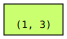

In [65]:
Source.from_file(filename=str(graph_selected.value))

## TensorRT Optimization Strategies

In [68]:
!pip install torch_tensorrt

  Created wheel for torch-tensorrt: filename=torch_tensorrt-0.0.0-py3-none-any.whl size=1353 sha256=9a4d72336254b2283ef91272185da594abd5597574ada050b1387f0e79425a5f
  Stored in directory: /root/.cache/pip/wheels/bd/85/38/0356ed8823299b7bc9fe50a3ebe7aa4580072453c0c623328e
Successfully built torch-tensorrt


In [88]:
import torch_tensorrt

model = BertClassifier().eval()

inputs = list([torch_tensorrt.Input(
          min_shape=[64,],
          opt_shape=[128,],
          max_shape=[512,],
          dtype=torch.int64,
        )])

enabled_precisions = set({torch.uint8, torch.int16, torch.int32, torch.int64})

trt_ts_module = torch_tensorrt.compile(model=model, inputs=inputs, enabled_precisions=enabled_precisions)

inputs = tokenizer.encode_plus(text=samples.tolist())
ids = torch.from_numpy(np.asarray(a=inputs['input_ids']))
ids_halved = ids.to('cuda').half()
torch.jit.save(trt_ts_module, "trt_ts_module.ts")

cprint(text=f'ids:\n{ids}', color='white')
cprint(text=f'ids_halved:\n{ids_halved}', color='magenta')

ValueError: ignored